# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1uAUJGEUzfNj6OsWNAimnYCw7eKaHhMUfU1MTj9YwYw4/edit?usp=sharing), [grading rubric](https://docs.google.com/document/d/1hKuRWqFcIdhOkow3Nljcm7PXzIkoa9c_aHkMKZDxWa0/edit?usp=sharing)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an outline to help you with your own approach.**_

## Project Setup

In [15]:
# import all necessary third-party modules

import math
import os

import re
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import math
import geopandas as gpd

In [16]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
UBER_CSV = "data/uber_rides_sample.csv"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [17]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [18]:
def get_and_clean_taxi_zones():
    '''
    This function is used for loading the taxi_zones.shp file and cleaning the file,
    including adding longitude and latitude columns by looking up the polygon,
    removing the duplicate LocationID, setting a new index, and removing useless columns
    '''
    
    #load taxi_zones shapefile
    taxi_zones_shapefile = gpd.read_file(TAXI_ZONES_SHAPEFILE)
    shp = taxi_zones_shapefile.to_crs(4326)
    
    #look up and get longitude column
    shp["longitude"]=shp.centroid.x
    #look up and get latitude column
    shp["latitude"]=shp.centroid.y
    
    #check if there are any duplicate values in LocationID 
    if shp.loc[shp['OBJECTID'] != shp['LocationID']]['LocationID'].count() != 0:
        #manually correct the duplicate values of LocationID
        shp.loc[shp['OBJECTID'] == 57, 'LocationID'] = 57
        shp.loc[shp['OBJECTID'] == 104, 'LocationID'] = 104
        shp.loc[shp['OBJECTID'] == 105, 'LocationID'] = 105
    
    #check if the index is 'OBJECTID'
    if shp.index.name != 'OBJECTID':
        #change the index to 'OBJECTID'
        shp = shp.set_index('OBJECTID')
    
    #only keep useful columns
    shp = shp[['LocationID','longitude','latitude']]
    
    #after cleaning, return the shp file
    return shp

In [19]:
get_and_clean_taxi_zones()

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["latitude"]=shp.centroid.y


,LocationID,longitude,latitude
OBJECTID,,,
1,1,-74.174000,40.691831
2,2,-73.831299,40.616745
3,3,-73.847422,40.864474
4,4,-73.976968,40.723752
5,5,-74.188484,40.552659
...,...,...,...
259,259,-73.852215,40.897932
260,260,-73.906306,40.744235
261,261,-74.013023,40.709139


### Calculate distance

In [20]:
def calculate_distance_with_coords(from_coord, to_coord):
    
    #use haversine formula to calculate the distance based on latitude and longitude
    
    #the earth radius in km
    R = 6371.0
    
    pickup_lat = math.radians(from_coord['pickup_latitude'])
    pickup_lon = math.radians(from_coord['pickup_longitude'])
    dropoff_lat = math.radians(to_coord['dropoff_latitude'])
    dropoff_lon = math.radians(to_coord['dropoff_longitude'])
    
    diff_lon = dropoff_lon - pickup_lon
    diff_lat = dropoff_lat - pickup_lat
    
    a = math.sin(diff_lat/2)**2 + math.cos(pickup_lat) * math.cos(dropoff_lat) * math.sin(diff_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    
    #return the calculated distance based on latitude and longitude
    return distance

In [21]:
def add_distance_column(df):
    
    #add one column call distance to the dataframe
    df['distance'] = df.apply(lambda x: calculate_distance_with_coords(
                            x[['pickup_latitude','pickup_longitude']], 
                            x[['dropoff_latitude','dropoff_longitude']]), axis=1)
    
    return df

### Process Taxi Data

In [22]:
def get_all_yellow_taxi_urls(TAXI_URL):
    """
    This function, get_parquet_files(), is used for collecting all urls of 
    yellow taxi data from 2009-01 to 2015-06 and save them into a list.
    """
    
    response = requests.get(TAXI_URL)
    soup = BeautifulSoup(response.content, 'html.parser')

    #write a regular expression to help pull out the desired links for Yellow Taxi Parquet files
    pattern = r"yellow_tripdata_(2009-(0[1-9]|1[0-2])|201[0-4]-(0[1-9]|1[0-2])|2015-(0[1-6]))"
    parquet_links_list = []
    
    for url in [a['href'] for a in soup.find_all('a')]:
        if re.search(pattern, url):
            parquet_links_list.append(url)
            
    return parquet_links_list

In [23]:
get_all_yellow_taxi_urls(TAXI_URL)

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-06.pa

In [94]:
def get_and_clean_month(taxi_data_url):
    
    #give an unique file name by slicing the corresponding month 
    filename = 'data/' + taxi_data_url.split('/')[-1] 
    
    #check if the file is already downloaded to the current path
    if not os.path.exists(filename):
        response = requests.get(taxi_data_url, stream=True)
        #download the monthly parquet file from correspond taxi url
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
    
    #clean the parquet file for corresponding month
    if '2009' in filename:
        
        df = pd.read_parquet(filename)
        
        df = df.dropna(subset={'vendor_name','Trip_Pickup_DateTime','Trip_Dropoff_DateTime','Payment_Type'})
        
        df = df[(df['Passenger_Count']>0)&(df['Trip_Distance'] > 0)&(df['Fare_Amt'] > 0)&(df['Tip_Amt']>=0)]
        
        df = df[['Trip_Pickup_DateTime','Start_Lon','Start_Lat','End_Lon','End_Lat','Tip_Amt']]
        
        df.rename(columns={'Trip_Pickup_DateTime':'pickup_datetime','Start_Lon':'pickup_longitude',
                           'Start_Lat':'pickup_latitude','End_Lon':'dropoff_longitude',
                           'End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'}, inplace=True)
    
    elif '2010' in filename:
        
        df = pd.read_parquet(filename)
        
        df = df.dropna(subset={'vendor_id','pickup_datetime','dropoff_datetime','payment_type'})
        
        df = df[(df['passenger_count']>0)&(df['trip_distance'] > 0)&(df['fare_amount'] > 0)&(df['tip_amount']>=0)]
        
        df = df[['pickup_datetime','pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','tip_amount']]
    
    elif '2011' in filename or '2012' in filename or '2013' in filename or '2014' in filename or '2015' in filename:
        
        df = pd.read_parquet(filename)
        
        df = df.dropna(subset={'VendorID','tpep_pickup_datetime','tpep_dropoff_datetime',
                               'PULocationID','DOLocationID','payment_type'})
        
        df = df[(df['passenger_count']>0)&(df['trip_distance'] > 0)&(df['fare_amount'] > 0)&(df['tip_amount']>=0)]
        
        df = df[['tpep_pickup_datetime','PULocationID','DOLocationID','tip_amount']]
        
        zones_file = get_and_clean_taxi_zones()
        
        df = pd.merge(df, zones_file, left_on="PULocationID", right_on="LocationID", how="left")
        df = pd.merge(df, zones_file, left_on="DOLocationID", right_on="LocationID", 
                             suffixes=("_PU", "_DO"), how="left")
        
        df = df[['tpep_pickup_datetime','longitude_PU','latitude_PU',
                 'longitude_DO','latitude_DO','tip_amount']]
        
        df.rename(columns={'tpep_pickup_datetime':'pickup_datetime',
                           'longitude_PU':'pickup_longitude','latitude_PU':'pickup_latitude',
                           'longitude_DO':'dropoff_longitude','latitude_DO':'dropoff_latitude'},inplace=True)
    
    #removing all data outside of the New York Box range
    
    #for pickup_longitude and pickup_latitude
    df = df[(df['pickup_longitude']>=NEW_YORK_BOX_COORDS[0][1])
            &(df['pickup_longitude']<=NEW_YORK_BOX_COORDS[1][1])
            &(df['pickup_latitude']>=NEW_YORK_BOX_COORDS[0][0])
            &(df['pickup_latitude']<=NEW_YORK_BOX_COORDS[1][0])]
    
    #for dropoff_longitude and dropoff_latitude
    df = df[(df['dropoff_longitude']>=NEW_YORK_BOX_COORDS[0][1])
            &(df['dropoff_longitude']<=NEW_YORK_BOX_COORDS[1][1])
            &(df['dropoff_latitude']>=NEW_YORK_BOX_COORDS[0][0])
            &(df['dropoff_latitude']<=NEW_YORK_BOX_COORDS[1][0])]
    
    #remove all trips with the same pickup_longitude and dropoff_longitude
    #and the same pickup_latitude and dropoff_latitude
    #which may result distance = 0 
    #filter out these values
    df = df[(df['pickup_longitude']!=df['dropoff_longitude'])
           &(df['pickup_latitude']!=df['dropoff_latitude'])]
    
    #change the type of "pickup_datetime" into python datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    
    #make sure all the data types are the desired ones
    df = df.astype({'pickup_longitude':'float64','pickup_latitude':'float64',
                    'dropoff_longitude':'float64','dropoff_latitude':'float64','tip_amount':'float64'})
    
    #since we need to match the amount of data from the taxi file with the one from the uber 
    #as we know that the cleaned uber data is about 195,000, 
    #we have total 78 months from 2009-01 to 2015-06, so 195,000/78 is about 2500 rows for each month
    df = df.sample(2500)
    
    #return the cleaned taxi data frame
    return df

In [95]:
def get_and_clean_taxi_data(parquet_urls):
    
    all_taxi_dataframes = []
    
    for parquet_url in parquet_urls:
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month(parquet_url)
        add_distance_column(dataframe)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    
    return taxi_data

In [96]:
def get_taxi_data():
    
    parquet_urls = get_all_yellow_taxi_urls(TAXI_URL)
    taxi_data = get_and_clean_taxi_data(parquet_urls)
    
    return taxi_data

In [97]:
taxi_data = get_taxi_data()

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["latitude"]=shp.centroid.y
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometr

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["latitude"]=shp.centroid.y
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometr

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["latitude"]=shp.centroid.y
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometr

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["latitude"]=shp.centroid.y
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp["longitude"]=shp.centroid.x
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/1136422984.py:15: UserWarning: Geometr

In [99]:
taxi_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
8581011,2015-01-21 18:07:02,-73.957012,40.780436,-73.978632,40.783961,1.00,1.862072
5878423,2015-01-15 12:21:49,-73.985156,40.748575,-73.984052,40.736824,0.00,1.309912
5136449,2015-01-13 18:39:35,-73.965146,40.756729,-73.945750,40.790011,0.00,4.045146
6301733,2015-01-16 10:38:57,-73.981532,40.773633,-73.978632,40.783961,1.45,1.174113
12202473,2015-01-31 02:20:49,-73.959905,40.710880,-73.990896,40.718938,0.00,2.761453
...,...,...,...,...,...,...,...
14486267,2009-12-22 09:57:08,-73.933309,40.795224,-73.991157,40.747186,4.85,7.229324
9379829,2009-12-29 14:55:00,-73.976635,40.764952,-73.987410,40.755588,0.00,1.381212
3235071,2009-12-31 09:03:06,-73.957543,40.765698,-74.006957,40.742594,2.00,4.891247
9700561,2009-12-02 07:54:47,-73.954295,40.770307,-73.978548,40.753523,0.00,2.766848


In [123]:
taxi_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
8581011,2015-01-21 18:07:02,-73.957012,40.780436,-73.978632,40.783961,1.00,1.862072
5878423,2015-01-15 12:21:49,-73.985156,40.748575,-73.984052,40.736824,0.00,1.309912
5136449,2015-01-13 18:39:35,-73.965146,40.756729,-73.945750,40.790011,0.00,4.045146
6301733,2015-01-16 10:38:57,-73.981532,40.773633,-73.978632,40.783961,1.45,1.174113
12202473,2015-01-31 02:20:49,-73.959905,40.710880,-73.990896,40.718938,0.00,2.761453


### Processing Uber Data

In [124]:
def load_and_clean_uber_data():
    
    #load in the uber csv file as a data frame by pandas, and set the first column as index
    df_uber = pd.read_csv(UBER_CSV, index_col=0)
        
    #removing the rows whose passenger count is less than or equal to 0, which is unpractical
    df_uber = df_uber[(df_uber['fare_amount']>0)&(df_uber['passenger_count']>0)]
    
    #only keeping useful columns
    df_uber = df_uber[['pickup_datetime','pickup_longitude','pickup_latitude',
                       'dropoff_longitude','dropoff_latitude']]
    
    #removing all data outside of the New York Box range
    
    #for pickup_longitude and pickup_latitude
    df_uber = df_uber[(df_uber['pickup_longitude']>=NEW_YORK_BOX_COORDS[0][1])
                  &(df_uber['pickup_longitude']<=NEW_YORK_BOX_COORDS[1][1])
                  &(df_uber['pickup_latitude']>=NEW_YORK_BOX_COORDS[0][0])
                  &(df_uber['pickup_latitude']<=NEW_YORK_BOX_COORDS[1][0])]
    
    #for dropoff_longitude and dropoff_latitude
    df_uber = df_uber[(df_uber['dropoff_longitude']>=NEW_YORK_BOX_COORDS[0][1])
                  &(df_uber['dropoff_longitude']<=NEW_YORK_BOX_COORDS[1][1])
                  &(df_uber['dropoff_latitude']>=NEW_YORK_BOX_COORDS[0][0])
                  &(df_uber['dropoff_latitude']<=NEW_YORK_BOX_COORDS[1][0])]
    
    #filter out distance = 0 
    df_uber = df_uber[(df_uber['pickup_longitude']!=df_uber['dropoff_longitude'])
                      &(df_uber['pickup_latitude']!=df_uber['dropoff_latitude'])]
    
    #change the type of "pickup_datetime" into python datetime
    df_uber['pickup_datetime'] = pd.to_datetime(df_uber['pickup_datetime'])
    
    #change all the data types into desired ones
    df_uber = df_uber.astype({'pickup_longitude':'float64','pickup_latitude':'float64',
                              'dropoff_longitude':'float64','dropoff_latitude':'float64'})
    
    #return the cleaned uber data frame
    return df_uber

In [125]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data()
    add_distance_column(uber_dataframe)
    return uber_dataframe

In [126]:
uber_data = get_uber_data()

In [128]:
uber_data

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
24238194,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683323
27835199,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.457590
44984355,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.036377
25894730,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.661683
17610152,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.475450
...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,0.112210
16382965,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1.875050
27804658,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,12.850319
20259894,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,3.539715


In [127]:
uber_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
24238194,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.683323
27835199,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,2.457590
44984355,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,5.036377
25894730,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,1.661683
17610152,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,4.475450


### Processing Weather Data

In [129]:
def get_all_weather_csvs():
    
    #initiate with an empty list 
    weather_csvs = []
    
    #iterate the year from 2009 to 2015
    for year in range(2009, 2016, 1):
        weather_csv = 'data/' + str(year) + '_weather.csv'
        weather_csvs.append(weather_csv)
    
    #return a list with all weathers files names from 2009 to 2015
    return weather_csvs

In [130]:
get_all_weather_csvs()

['data/2009_weather.csv',
 'data/2010_weather.csv',
 'data/2011_weather.csv',
 'data/2012_weather.csv',
 'data/2013_weather.csv',
 'data/2014_weather.csv',
 'data/2015_weather.csv']

In [271]:
def get_and_clean_weather_data_hourly(csv_file):
    
    #load a certain weather csv file into data frame
    df_weather = pd.read_csv(csv_file)
    
    #transform the data type of column 'Date' into a datetime format
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    
    #split hour and minute of a datetime and create corresponding columns respectively
    df_weather['timestamp_hour'] = df_weather['DATE'].apply(lambda x:str(x.hour).zfill(2))
    df_weather['timestamp_minute'] = df_weather['DATE'].apply(lambda x:str(x.minute).zfill(2))

    #as I manually observe that the daily data is always collected at the last minute of that day
    #I create a new data frame by filtering the datetime as the last minute of a day
    df_weather_day_end = df_weather[(df_weather['timestamp_hour'] == '23')
                                & (df_weather['timestamp_minute'] == '59')]
    
    #use the index to drop all daily collected weather data from the total weather data
    #after that, we can get the pure hourly weather data 
    df_weather_hourly = df_weather.drop(df_weather_day_end.index)
    
    #only keep the useful columns
    df_weather_hourly = df_weather_hourly[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    
    # https://stackoverflow.com/questions/58807577/pandas-dataframe-extracting-float-values-from-string-in-a-column
    #since I found that there are some data with units, strip all the units and only keep the numeric values
    df_weather_hourly['HourlyPrecipitation'] = pd.to_numeric(
        df_weather_hourly['HourlyPrecipitation'].str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')
    
    #As the documentation mentions that the blank/null values indicate that
    #no precipitation was observed/reported for the hour ending at that time
    #also, the value of 'T' means trace amount of precipitation, 
    #therefore, we can directly fill all these values as 0
    df_weather_hourly['HourlyPrecipitation'] = df_weather_hourly['HourlyPrecipitation'].fillna(0)
    
    #since there are some rows whose hourly wind speed is null
    #as this is a very small amount, we can drop these values, which will not affect the whole trend
    #by the law of large numbers
    df_weather_hourly = df_weather_hourly.dropna(subset='HourlyWindSpeed')
    
    #reset the index
    df_weather_hourly.reset_index(inplace=True, drop=True)
    
    #need to check if this is needed
    #rename the essential columns
    df_weather_hourly.rename(columns={'DATE':'date','HourlyPrecipitation':'hourly_precipitation',
                                      'HourlyWindSpeed':'hourly_wind_speed'}, inplace=True)
    
    #make sure all the data types are the desired ones
    df_weather_hourly = df_weather_hourly.astype({'hourly_precipitation':'float64',
                                                  'hourly_wind_speed':'float64'})
    
    #need to check if this is needed
    #make sure the 'Date' columns follow datetime format
    df_weather_hourly['date'] = pd.to_datetime(df_weather_hourly['date'])
    
    #return the cleaned hourly weather data
    return df_weather_hourly

In [282]:
def get_and_clean_weather_data_daily(csv_file):
    
    #load a certain weather csv file into data frame
    df_weather = pd.read_csv(csv_file)
    
    #transform the data type of column 'Date' into a datetime format
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    
    #split hour and minute of a datetime and create corresponding columns respectively
    df_weather['timestamp_hour'] = df_weather['DATE'].apply(lambda x:str(x.hour).zfill(2))
    df_weather['timestamp_minute'] = df_weather['DATE'].apply(lambda x:str(x.minute).zfill(2))

    #as I manually observe that the daily data is always collected at the last minute of that day
    #I create a new data frame by filtering the datetime as the last minute of a day
    df_weather_day_end = df_weather[(df_weather['timestamp_hour'] == '23')
                                & (df_weather['timestamp_minute'] == '59')]
    
    #use the index to drop all daily collected weather data from the total weather data
    #after that, we can get the pure hourly weather data 
    df_weather_hourly = df_weather.drop(df_weather_day_end.index)
    
    #only keep the useful columns
    df_weather_hourly = df_weather_hourly[['DATE','HourlyPrecipitation','HourlyWindSpeed']]
    
    # https://stackoverflow.com/questions/58807577/pandas-dataframe-extracting-float-values-from-string-in-a-column
    #found some data with units, clear all the units and only keep the numeric values
    df_weather_hourly['HourlyPrecipitation'] = pd.to_numeric(
        df_weather_hourly['HourlyPrecipitation'].str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')
    
    #As the documentation mentions that the blank/null values indicate that
    #no precipitation was observed/reported for the hour ending at that time
    #also, the value of 'T' means trace amount of precipitation, 
    #therefore, we can directly fill all these values as 0
    df_weather_hourly['HourlyPrecipitation'] = df_weather_hourly['HourlyPrecipitation'].fillna(0)
    
    #since there are some rows whose hourly wind speed is null
    #as this is a very small amount, we can drop these values, which will not affect the whole trend
    #by the law of large numbers
    df_weather_hourly = df_weather_hourly.dropna(subset='HourlyWindSpeed')
    
    #since we can get mostly the hourly data from all weather files
    #however, there are too many missing values in a daily frequency, especially from 2009 to 2012
    #using hourly data to populate the daily data 
    #also, by observing the daily precipitation and daily average wind speed columns from 2013 to 2015
    #the way to calculate the daily precipitation is to take summation
    #the way to calculate the daily average wind speed is to take average of samples in a 24-hours interval
    df_weather_daily = df_weather_hourly.groupby(
        df_weather_hourly['DATE'].dt.date).agg({'HourlyPrecipitation': 'sum', 'HourlyWindSpeed': 'mean'})
    
    #since the index for daily df is the date, create another date column DATE with index values
    df_weather_daily['DATE'] = df_weather_daily.index
    
    #make sure the DATE as the datetime format
    df_weather_daily['DATE'] = pd.to_datetime(df_weather_daily['DATE'])
    
    #reset the default index as row number
    df_weather_daily.reset_index(inplace=True, drop=True)
    
    #rename the essential columns
    df_weather_daily.rename(columns={'DATE':'date',
                                     'HourlyPrecipitation':'daily_precipitation',
                                     'HourlyWindSpeed':'daily_average_wind_speed'}, inplace=True)
    
    #make sure all the data types are the desired ones
    df_weather_daily = df_weather_daily.astype({'daily_precipitation':'float64',
                                                'daily_average_wind_speed':'float64'})
    
    #rearrange the order of all columns
    df_weather_daily = df_weather_daily.reindex(columns=['date','daily_precipitation','daily_average_wind_speed'])
        
    #return the cleaned version of daily weather data
    return df_weather_daily

In [283]:
def get_and_clean_sunrise_sunset_data(csv_file):
    
    #load a certain weather csv file into data frame
    df_weather = pd.read_csv(csv_file)
    
    #transform the data type of column 'Date' into a datetime format
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    
    #split hour and minute of a datetime and create corresponding columns respectively
    df_weather['timestamp_hour'] = df_weather['DATE'].apply(lambda x:str(x.hour).zfill(2))
    df_weather['timestamp_minute'] = df_weather['DATE'].apply(lambda x:str(x.minute).zfill(2))

    #as I manually observe that the daily data is always collected at the last minute of that day
    #create a new data frame with only the daily data
    df_weather_sun = df_weather[(df_weather['timestamp_hour'] == '23')
                                & (df_weather['timestamp_minute'] == '59')]
    
    #only keep the important columns
    df_weather_sun = df_weather_sun[['DATE','Sunrise','Sunset']]
    
    #since we can't use any other columns to populate the null values
    #directly drop the null values
    df_weather_sun = df_weather_sun.dropna(subset=['Sunrise','Sunset'])
    
    #rename the essential columns
    df_weather_sun.rename(columns={'DATE':'date','Sunrise':'sunrise',
                                   'Sunset':'sunset'}, inplace=True)
    
    #rearrange the index, counting from zero and increment
    df_weather_sun.reset_index(inplace=True, drop=True)
    
    #make sure the DATE as the datetime format
    df_weather_sun['date'] = pd.to_datetime(df_weather_sun['date'])
    
    return df_weather_sun

In [284]:
def load_and_clean_weather_data():
    
    weather_csv_files = get_all_weather_csvs()
    
    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = get_and_clean_weather_data_hourly(csv_file)
        daily_dataframe = get_and_clean_weather_data_daily(csv_file)
        sun_dataframe = get_and_clean_sunrise_sunset_data(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        sun_dataframes.append(sun_dataframe)
        
    # create two dataframes with hourly & daily data from every year
    # create one dataframe with only sunrise and sunset data
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)
    
    #make sure all index are counting the row number from 0 and gradually incrementing
    hourly_data.reset_index(inplace=True, drop=True)
    daily_data.reset_index(inplace=True, drop=True)
    sun_data.reset_index(inplace=True, drop=True)
    
    return hourly_data, daily_data, sun_data

In [285]:
hourly_data, daily_data, sun_data = load_and_clean_weather_data()

/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/3617500815.py:4: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv(csv_file)
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/3538953825.py:4: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv(csv_file)
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/492313200.py:4: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv(csv_file)
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/3617500815.py:4: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv(csv_file)
/var/folders/ln/t3cf08b1653_3b58vkrg2_9c0000gn/T/ipykernel_884/3538953825.py:4: DtypeWarning: Columns (8,9,10,17) ha

In [286]:
hourly_data.head()

,date,hourly_precipitation,hourly_wind_speed
0,2009-01-01 00:51:00,0.0,18.0
1,2009-01-01 01:51:00,0.0,18.0
2,2009-01-01 02:51:00,0.0,18.0
3,2009-01-01 03:51:00,0.0,8.0
4,2009-01-01 04:51:00,0.0,11.0


In [287]:
hourly_data

,date,hourly_precipitation,hourly_wind_speed
0,2009-01-01 00:51:00,0.0,18.0
1,2009-01-01 01:51:00,0.0,18.0
2,2009-01-01 02:51:00,0.0,18.0
3,2009-01-01 03:51:00,0.0,8.0
4,2009-01-01 04:51:00,0.0,11.0
...,...,...,...
73702,2015-12-31 18:51:00,0.0,3.0
73703,2015-12-31 19:51:00,0.0,6.0
73704,2015-12-31 20:51:00,0.0,10.0
73705,2015-12-31 22:51:00,0.0,7.0


In [288]:
daily_data.head()

,date,daily_precipitation,daily_average_wind_speed
0,2009-01-01,0.0,11.041667
1,2009-01-02,0.0,6.806452
2,2009-01-03,0.0,9.875000
3,2009-01-04,0.0,7.370370
4,2009-01-05,0.0,6.925926


In [289]:
daily_data

,date,daily_precipitation,daily_average_wind_speed
0,2009-01-01,0.00,11.041667
1,2009-01-02,0.00,6.806452
2,2009-01-03,0.00,9.875000
3,2009-01-04,0.00,7.370370
4,2009-01-05,0.00,6.925926
...,...,...,...
2536,2015-12-27,0.17,4.911111
2537,2015-12-28,0.03,8.208333
2538,2015-12-29,0.93,7.787234
2539,2015-12-30,0.29,4.184211


In [290]:
sun_data.head()

,date,sunrise,sunset
0,2009-01-02 23:59:00,720.0,1640.0
1,2009-01-06 23:59:00,720.0,1644.0
2,2009-01-07 23:59:00,720.0,1645.0
3,2009-01-10 23:59:00,720.0,1648.0
4,2009-01-11 23:59:00,720.0,1649.0


In [291]:
sun_data

,date,sunrise,sunset
0,2009-01-02 23:59:00,720.0,1640.0
1,2009-01-06 23:59:00,720.0,1644.0
2,2009-01-07 23:59:00,720.0,1645.0
3,2009-01-10 23:59:00,720.0,1648.0
4,2009-01-11 23:59:00,720.0,1649.0
...,...,...,...
1821,2015-12-27 23:59:00,719.0,1635.0
1822,2015-12-28 23:59:00,719.0,1636.0
1823,2015-12-29 23:59:00,720.0,1636.0
1824,2015-12-30 23:59:00,720.0,1637.0


## Part 2: Storing Cleaned Data

In [292]:
engine = db.create_engine(DATABASE_URL)

In [293]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    date DATE,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    date DATE,
    daily_precipitation FLOAT,
    daily_average_wind_speed FLOAT
);
"""

# SUN_WEATHER_SCHEMA = """
#     CREATE TABLE IF NOT EXISTS sun_weather
#     (
#         id INTEGER PRIMARY KEY,
#         Date DATETIME,
#         Sunset FLOAT64,
#         Sunrise FLOAT64
#     );
# """ed

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    tip_amount FLOAT,
    distance FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
    );
"""

In [294]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [295]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

In [296]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html

In [297]:
def write_dataframes_to_table(table_to_df_dict):
    
    for table_name, dataframe in map_table_name_to_dataframe.items():
        dataframe.to_sql(table_name, con=engine, if_exists='append', index=False)
    
    return 'Mission Completed'

In [298]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [299]:
write_dataframes_to_table(map_table_name_to_dataframe)

'Mission Completed'

## Part 3: Understanding the Data

In [300]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as f:
        f.write(query)

### Query 1

#### For 01-2009 through 06-2015, show the popularity of Yellow Taxi rides for each hour of the day.

In [301]:
QUERY_1_FILENAME = "taxi_each_hour_popularity.sql"

QUERY_1 = """
SELECT 
    strftime('%H', pickup_datetime) AS hour,
    COUNT(id) AS popularity
FROM 
    taxi_trips
WHERE
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY
    hour
ORDER BY
    popularity DESC
"""

In [302]:
engine.execute(QUERY_1).fetchall()

[('19', 12383),
 ('18', 11690),
 ('20', 11432),
 ('21', 11211),
 ('22', 11054),
 ('23', 9756),
 ('14', 9747),
 ('17', 9732),
 ('12', 9653),
 ('13', 9412),
 ('15', 9240),
 ('09', 9011),
 ('11', 8818),
 ('08', 8763),
 ('10', 8725),
 ('16', 8096),
 ('00', 7846),
 ('07', 6925),
 ('01', 5868),
 ('02', 4294),
 ('06', 3972),
 ('03', 3089),
 ('04', 2287),
 ('05', 1913)]

In [303]:
len(engine.execute(QUERY_1).fetchall())

24

In [304]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

#### For the same time frame, show the popularity of Uber rides for each day of the week.

In [305]:
QUERY_2_FILENAME = "uber_each_day_popularity.sql"

QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day,
    COUNT(id) as popularity
FROM 
    uber_trips
WHERE
    pickup_datetime BETWEEN '2009-01-01' AND '2015-06-30'
GROUP BY
    day
ORDER BY
    popularity DESC
"""

In [306]:
engine.execute(QUERY_2).fetchall()

[('5', 29732),
 ('6', 29198),
 ('4', 28949),
 ('3', 27962),
 ('2', 27071),
 ('0', 25493),
 ('1', 24269)]

In [307]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

#### What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [308]:
QUERY_3_FILENAME = "hired_trips_95%_percentile_July.sql"

QUERY_3 = """
WITH hired_trips AS (
    SELECT pickup_datetime, distance 
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
    )
SELECT 
    distance
FROM 
    hired_trips
WHERE 
    pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
ORDER BY 
    distance ASC
LIMIT 1
OFFSET (
    SELECT COUNT(*) 
    FROM hired_trips
    WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
    ) * 95 / 100 - 1
"""

In [309]:
engine.execute(QUERY_3).fetchall()

[(10.41196195829923,)]

In [310]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

#### What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [311]:
QUERY_4_FILENAME = "top_10_days_highest_with_avg_distance.sql"

QUERY_4 = """
WITH hired_trips AS (
    SELECT pickup_datetime, distance
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2009-12-31'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2009-01-01' AND '2009-12-31'
    )
SELECT 
    DATE(pickup_datetime) as date, 
    COUNT(*) as total_number, 
    AVG(distance) as avg_distance
FROM hired_trips
GROUP BY date
ORDER BY total_number DESC
LIMIT 10
"""

In [312]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 221, 3.016592875793254),
 ('2009-02-20', 218, 3.1089744402912753),
 ('2009-04-03', 216, 2.5835324801263675),
 ('2009-10-23', 214, 2.883515238241926),
 ('2009-05-16', 213, 2.887044715760733),
 ('2009-02-12', 212, 2.9078997199046563),
 ('2009-06-05', 208, 2.928685023638607),
 ('2009-09-18', 207, 3.2136122283866233),
 ('2009-08-14', 207, 3.403669204801021),
 ('2009-01-24', 204, 2.5279740822104353)]

In [313]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

#### Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [314]:
QUERY_5_FILENAME = "top_10_windiest_days_with_hired_trips.sql"

QUERY_5 = """
SELECT 
    DATE(daily_weather.date) as date,
    daily_weather.daily_average_wind_speed as daily_avg,
    COUNT(*)
FROM (
    SELECT pickup_datetime 
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2014-01-01' AND '2014-12-31'
    UNION ALL
    SELECT pickup_datetime
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2014-01-01' AND '2014-12-31'
    ) AS hired_trips
INNER JOIN daily_weather
ON 
    DATE(hired_trips.pickup_datetime) = DATE(daily_weather.date)
WHERE 
    date BETWEEN '2014-01-01' AND '2014-12-31'
GROUP BY 
    date
ORDER BY 
    daily_avg DESC
LIMIT 10 
"""

In [315]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.0, 192),
 ('2014-01-07', 13.083333333333334, 158),
 ('2014-01-02', 12.727272727272727, 130),
 ('2014-02-13', 12.226415094339623, 135),
 ('2014-03-26', 11.954545454545455, 191),
 ('2014-03-29', 11.914893617021276, 207),
 ('2014-12-07', 11.6, 153),
 ('2014-12-09', 11.26923076923077, 177),
 ('2014-12-08', 11.266666666666667, 169),
 ('2014-11-02', 10.826086956521738, 171)]

In [316]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

#### During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the hourly wind speed? 

In [327]:
QUERY_6_FILENAME = "Hurricane_Sandy_trips"

QUERY_6 = """
WITH hired_trips AS (
    SELECT pickup_datetime 
    FROM taxi_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-06'
    UNION ALL
    SELECT pickup_datetime
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-06'
    )
SELECT 
    strftime('%Y-%m-%d %H', hourly_weather.date) as hour_in_day,
    COALESCE(COUNT(*), 0),
    hourly_weather.hourly_precipitation,
    hourly_weather.hourly_wind_speed
FROM hourly_weather
LEFT JOIN hired_trips
ON 
    strftime('%Y-%m-%d %H', hourly_weather.date) = strftime('%Y-%m-%d %H', hired_trips.pickup_datetime)
WHERE 
    hour_in_day BETWEEN '2012-10-22' AND '2012-11-06'
GROUP BY 
    hour_in_day
ORDER BY 
    hour_in_day ASC
"""

In [328]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00', 2, 0.0, 7.0),
 ('2012-10-22 01', 1, 0.0, 5.0),
 ('2012-10-22 02', 2, 0.0, 7.0),
 ('2012-10-22 03', 1, 0.0, 0.0),
 ('2012-10-22 04', 1, 0.0, 0.0),
 ('2012-10-22 05', 2, 0.0, 0.0),
 ('2012-10-22 06', 4, 0.0, 5.0),
 ('2012-10-22 07', 7, 0.0, 3.0),
 ('2012-10-22 08', 9, 0.0, 3.0),
 ('2012-10-22 09', 12, 0.0, 5.0),
 ('2012-10-22 12', 6, 0.0, 11.0),
 ('2012-10-22 14', 6, 0.0, 7.0),
 ('2012-10-22 15', 8, 0.0, 6.0),
 ('2012-10-22 16', 8, 0.0, 3.0),
 ('2012-10-22 17', 8, 0.0, 7.0),
 ('2012-10-22 18', 13, 0.0, 5.0),
 ('2012-10-22 19', 6, 0.0, 5.0),
 ('2012-10-22 20', 14, 0.0, 3.0),
 ('2012-10-22 21', 8, 0.0, 0.0),
 ('2012-10-22 22', 14, 0.0, 3.0),
 ('2012-10-22 23', 5, 0.0, 3.0),
 ('2012-10-23 00', 5, 0.0, 3.0),
 ('2012-10-23 01', 2, 0.0, 0.0),
 ('2012-10-23 02', 1, 0.0, 3.0),
 ('2012-10-23 03', 1, 0.0, 0.0),
 ('2012-10-23 04', 1, 0.0, 3.0),
 ('2012-10-23 05', 2, 0.0, 0.0),
 ('2012-10-23 06', 5, 0.0, 0.0),
 ('2012-10-23 07', 13, 0.0, 0.0),
 ('2012-10-23 08', 11, 0.0, 0.0),
 ('

In [329]:
#only 340???
len(engine.execute(QUERY_6).fetchall())

340

In [330]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [362]:
def get_data_for_visual_1():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    visual_1_df = pd.read_sql_query(QUERY_1, engine)
    
    return visual_1_df

In [369]:
# use a more descriptive name for your function
def plot_barplot_for_QUERY_1():
    
    figure = plt.figure(figsize=(10, 5))
    
    plot_df_1 = get_data_for_visual_1()  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    plt.bar(plot_df_1['hour'], plot_df_1['popularity'], color = 'maroon')
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    plt.xlabel("Hour in 24-Hours Interval")
    plt.ylabel("Taxi Popularity")
    plt.title("Bar Plot for Taxi Popularity in Every Hour")
    
    plt.show();

In [ ]:
#rearrange the x axis from 00 to 23?

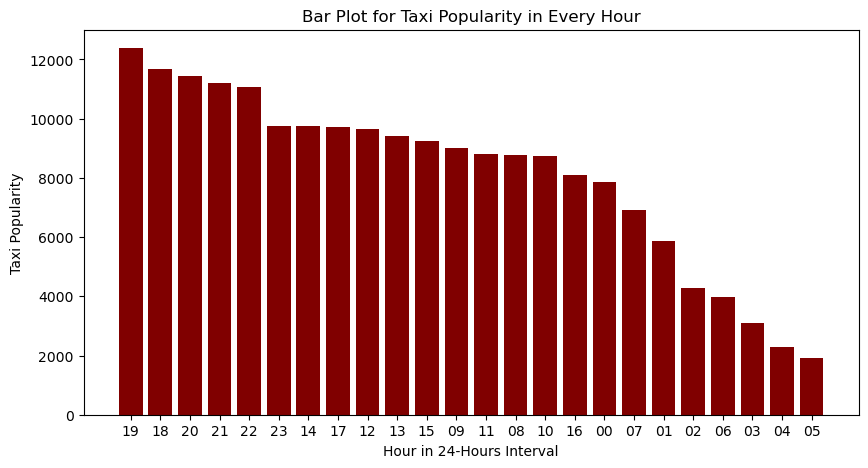

In [370]:
visual_1_df = get_data_for_visual_1()
plot_barplot_for_QUERY_1(visual_1_df)

### Visualization 2

In [ ]:
#what is the mean here actually indicating?

In [372]:
def get_data_for_visual_2():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    QUERY_taxi = """
    SELECT strftime('%m', pickup_datetime) AS month, AVG(distance) as taxi_mean
    FROM taxi_trips
    GROUP BY month
    """
    
    QUERY_uber = """
    SELECT strftime('%m', pickup_datetime) AS month, AVG(distance) as uber_mean
    FROM uber_trips
    GROUP BY month
    """
    visual_2_taxi = pd.read_sql_query(QUERY_taxi, engine)
    visual_2_uber = pd.read_sql_query(QUERY_uber, engine)
    
    return visual_2_taxi, visual_2_uber

In [373]:
visual_2_taxi, visual_2_uber = get_data_for_visual_2()

In [374]:
visual_2_taxi

,month,taxi_mean
0,01,3.350206
1,02,3.322326
2,03,3.420364
3,04,3.462169
4,05,3.512558
5,06,3.519849
6,07,3.448786
7,08,3.521156
8,09,3.545952
9,10,3.472004


In [375]:
visual_2_uber

,month,uber_mean
0,01,3.169433
1,02,3.222194
2,03,3.260570
3,04,3.329786
4,05,3.456009
5,06,3.420498
6,07,3.397523
7,08,3.428650
8,09,3.391279
9,10,3.386445


In [ ]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    
    figure = plt.figure(figsize=(10, 5))
    
    plot_df_1 = get_data_for_visual_1()  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    plt.bar(plot_df_1['hour'], plot_df_1['popularity'], color = 'maroon')
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    plt.xlabel("Hour in 24-Hours Interval")
    plt.ylabel("Taxi Popularity")
    plt.title("Bar Plot for Taxi Popularity in Every Hour")
    
    plt.show()

### Visualization 3

In [371]:
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

In [376]:
def get_data_for_visual_3():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    QUERY_LGA = """
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) as dropoff_number
    FROM (
        SELECT pickup_datetime 
        FROM taxi_trips
        WHERE 
            dropoff_longitude BETWEEN -73.891745 AND -73.854838 
        AND 
            dropoff_latitude BETWEEN 40.763589 AND 40.778865
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        ) AS hired_trips
    GROUP BY day
    """
    
    QUERY_JFK = """
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) as dropoff_number
    FROM (
        SELECT pickup_datetime 
        FROM taxi_trips
        WHERE 
            dropoff_longitude BETWEEN -73.795642 AND -73.766264
        AND 
            dropoff_latitude BETWEEN 40.639263 AND 40.651376
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        ) AS hired_trips
    GROUP BY day
    """
    
    QUERY_EWR = """
    SELECT strftime('%w', pickup_datetime) AS day, COUNT(*) as dropoff_number
    FROM (
        SELECT pickup_datetime 
        FROM taxi_trips
        WHERE 
            dropoff_longitude BETWEEN -74.194028 AND -74.165205
        AND 
            dropoff_latitude BETWEEN 40.686794 AND 40.699680
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        ) AS hired_trips
    GROUP BY day
    """
    
    visual_3_LGA = pd.read_sql_query(QUERY_LGA, engine)
    visual_3_JFK = pd.read_sql_query(QUERY_JFK, engine)
    visual_3_EWR = pd.read_sql_query(QUERY_EWR, engine)
    
    return visual_3_LGA, visual_3_JFK, visual_3_EWR

In [377]:
visual_3_LGA, visual_3_JFK, visual_3_EWR = get_data_for_visual_3()

In [378]:
visual_3_LGA

,day,dropoff_number
0,0,25863
1,1,24647
2,2,27448
3,3,28353
4,4,29365
5,5,30158
6,6,29408


In [379]:
visual_3_JFK

,day,dropoff_number
0,0,25708
1,1,24434
2,2,27288
3,3,28150
4,4,29160
5,5,29952
6,6,29360


In [380]:
visual_3_EWR

,day,dropoff_number
0,0,25525
1,1,24302
2,2,27164
3,3,28004
4,4,28987
5,5,29777
6,6,29228


In [385]:
def plot_visual_3():
    
    figure = plt.figure(figsize=(10, 5))
    
    df1, df2, df3 = get_data_for_visual_3()  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    plt.bar(df1['day'], df1['dropoff_number'], color = 'red')
    plt.bar(df2['day'], df2['dropoff_number'], bottom = df1['dropoff_number'], color = 'green')
    plt.bar(df3['day'], df3['dropoff_number'], bottom = df1['dropoff_number'] + df2['dropoff_number'], 
            color = 'blue')
    
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    plt.xlabel("Day in 7-Days Week")
    plt.ylabel("The Number of Drop_offs from Uber and Taxi")
    plt.legend(["LGA", "JFK", "EWR"], loc="upper left")
    plt.title("Most Popular Day of the week for Drop-offs for Each Airport")
    plt.show()

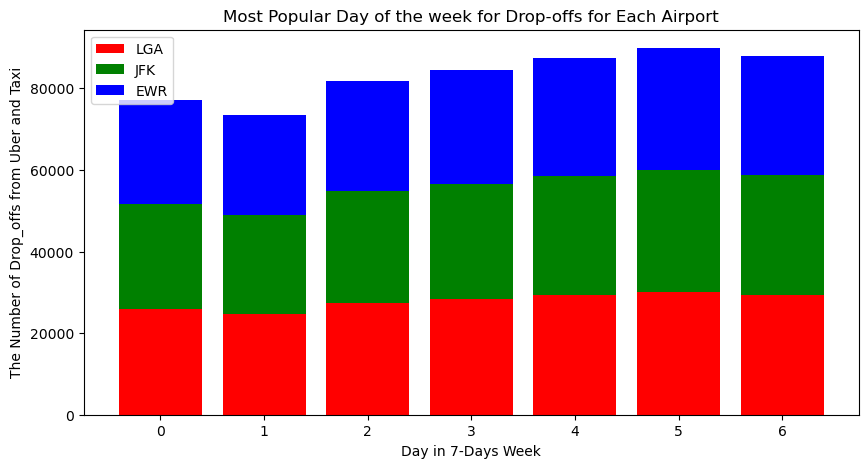

In [386]:
plot_visual_3()

### Visualization 4

In [387]:
def get_data_for_visual_4():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    QUERY_hired_trips = """
    SELECT hired_trips.pickup_latitude, hired_trips.pickup_longitude
    FROM (
        SELECT pickup_latitude, pickup_longitude
        FROM taxi_trips
        UNION ALL
        SELECT pickup_latitude, pickup_longitude
        FROM uber_trips
        ) AS hired_trips
    """
    
    df_hired_trips = pd.read_sql_query(QUERY_hired_trips, engine)
    
    return df_hired_trips

In [388]:
get_data_for_visual_4()

,pickup_latitude,pickup_longitude
0,40.780436,-73.957012
1,40.748575,-73.985156
2,40.756729,-73.965146
3,40.773633,-73.981532
4,40.710880,-73.959905
...,...,...
387733,40.739367,-73.987042
387734,40.736837,-73.984722
387735,40.756487,-73.986017
387736,40.725452,-73.997124


### Visualization 5

In [389]:
def get_data_for_visual_5():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    QUERY_taxi = """
    SELECT tip_amount, distance
    FROM taxi_trips
    """
    
    df_taxi_tip = pd.read_sql_query(QUERY_taxi, engine)
    
    return df_taxi_tip

In [415]:
#get_data_for_visual_5()

In [416]:
def scatter_plot_tip_distance():
    
    figure = plt.figure(figsize=(10, 5))
    
    df_taxi_tip = get_data_for_visual_5()  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    df_taxi_tip = df_taxi_tip[(df_taxi_tip['distance']<=20)
                              &(df_taxi_tip['tip_amount']>0)
                              &(df_taxi_tip['tip_amount']<=20)].sample(1000)
    
    plt.scatter(df_taxi_tip['distance'], df_taxi_tip['tip_amount'], color = 'cornflowerblue')
    
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    
    plt.xlabel("Distance")
    plt.ylabel("Tip Amount")
    plt.title("Scatter Plot for Comparing Tip Amount versus Distance for Yellow Taxi Rides")
    
    plt.show()

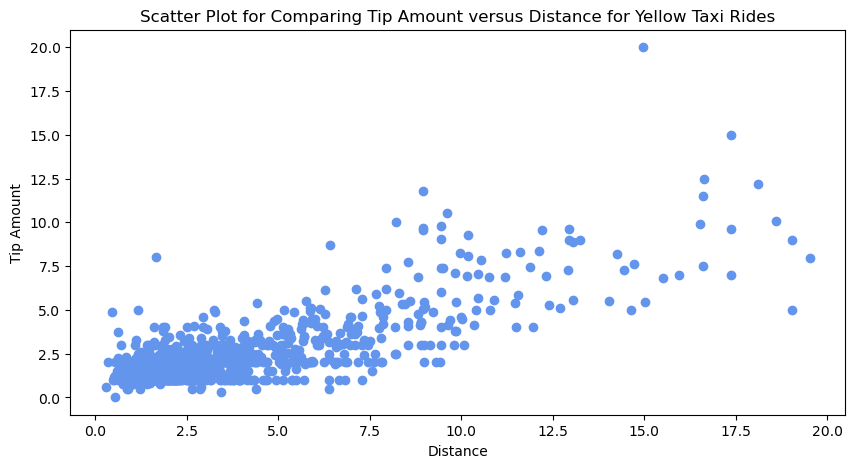

In [417]:
scatter_plot_tip_distance()

### Visualization 6

In [426]:
def get_data_for_visual_6():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    QUERY_tip_precipitation = """
    SELECT 
        DATE(daily_weather.date) as date,
        daily_weather.daily_precipitation as daily_precipitation,
        SUM(tip_amount) as daily_tips
    FROM (
        SELECT pickup_datetime, tip_amount
        FROM taxi_trips
        ) AS taxi_tips
    INNER JOIN daily_weather
    ON 
        DATE(taxi_tips.pickup_datetime) = DATE(daily_weather.date)
    GROUP BY 
        date
    """
    df_tip_precipitation = pd.read_sql_query(QUERY_tip_precipitation, engine)
    
    return df_tip_precipitation

In [427]:
df_tip_precipitation = get_data_for_visual_6()

In [428]:
df_tip_precipitation[(df_tip_precipitation['daily_precipitation']>0)&(df_tip_precipitation['daily_tips']<300)]

,date,daily_precipitation,daily_tips
5,2009-01-06,0.12,47.90
6,2009-01-07,1.82,28.94
9,2009-01-10,0.41,43.70
10,2009-01-11,0.51,35.33
14,2009-01-15,0.10,48.59
...,...,...,...
2349,2015-06-21,2.14,82.26
2351,2015-06-23,0.02,133.87
2355,2015-06-27,2.60,136.16
2356,2015-06-28,0.60,97.22


In [431]:
def scatter_plot_tip_precipitation(dataframe):
    
    figure = plt.figure(figsize=(10, 5))
    
    dataframe = dataframe[(dataframe['daily_precipitation']>0)
                          &(dataframe['daily_tips']<300)]
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    plt.scatter(dataframe['daily_precipitation'], 
                dataframe['daily_tips'], color = 'darkolivegreen')
    
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    
    plt.xlabel("Daily Precipitaion")
    plt.ylabel("Daily Tip Amount")
    plt.title("Scatter Plot for Comparing Tip Amount versus Daily Precipitation for Yellow Taxi Rides")
    
    plt.show()

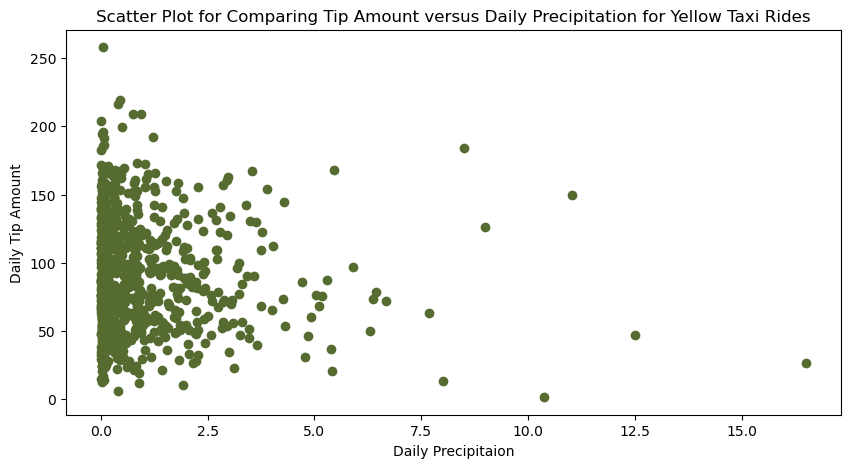

In [432]:
scatter_plot_tip_precipitation(df_tip_precipitation)